In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, GlobalAveragePooling2D, Dense, Dropout, concatenate, 
    Input, LayerNormalization, MultiHeadAttention, Lambda, Reshape
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import TFAutoModel, AutoTokenizer
from PIL import ImageFile
import matplotlib.pyplot as plt

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import transformers
transformers.logging.set_verbosity_error() 

In [3]:
DATASET_FOLDER = '../input/memotion-dataset-7k/memotion_dataset_7k/'

# Load CSV
df = pd.read_csv(os.path.join(DATASET_FOLDER, 'labels.csv'))

# Clean Data
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df.drop(columns=['text_ocr'], errors='ignore', inplace=True)
df.dropna(subset=['text_corrected'], inplace=True)

# Define mapping dictionary for 5-class sentiment
sentiment_map = {
    'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4
}

# Map 5-class sentiment to numeric using map (avoids FutureWarning)
df['overall_sentiment'] = df['overall_sentiment'].map(sentiment_map).astype('int64')

# Remap to 3 classes
def map_5_to_3(val):
    if val in [0, 1]: return 0  # negative
    elif val == 2: return 1     # neutral
    else: return 2              # positive

df['sentiment_3'] = df['overall_sentiment'].apply(map_5_to_3)
df.dropna(subset=['sentiment_3'], inplace=True)

In [5]:
df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment,sentiment_3
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,4,2
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,4,2
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,3,2
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,3,2
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,2,1


In [6]:
width, height = 100, 100
image_paths = []

# Collect valid image paths
for i, row in df.iterrows():
    img_path = os.path.join(DATASET_FOLDER, 'images', row['image_name'])
    if os.path.exists(img_path):
        image_paths.append(img_path)
    else:
        df.drop(index=i, inplace=True)

df.reset_index(drop=True, inplace=True)

# Load images into array
X_images = []
for path in image_paths:
    try:
        img = image.load_img(path, target_size=(width, height), color_mode='rgb')
        img_array = image.img_to_array(img) / 255.0
        X_images.append(img_array)
    except Exception as e:
        print(f"[Skipping] {path} due to error: {e}")

X_images = np.array(X_images)
Y = df['sentiment_3'].values
print("Loaded images shape:", X_images.shape)
print("Labels shape:", Y.shape)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loaded images shape: (6987, 100, 100, 3)
Labels shape: (6987,)


In [8]:
idxs = np.arange(len(df))
train_idx, test_idx = train_test_split(idxs, test_size=0.2, random_state=42, stratify=Y)

# Split images and labels
X_train_images = X_images[train_idx]
X_test_images = X_images[test_idx]
y_train = Y[train_idx]
y_test = Y[test_idx]

# Split text
all_texts = df['text_corrected'].values
X_train_text = all_texts[train_idx]
X_test_text = all_texts[test_idx]

print("Train images:", X_train_images.shape, "Train labels:", y_train.shape)
print("Test images:", X_test_images.shape, "Test labels:", y_test.shape)

Train images: (5589, 100, 100, 3) Train labels: (5589,)
Test images: (1398, 100, 100, 3) Test labels: (1398,)


In [9]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [10]:
base_model_1 = tf.keras.applications.ResNet50(
    input_shape=(width, height, 3), include_top=False, weights='imagenet'
)
base_model_2 = tf.keras.applications.VGG16(
    input_shape=(width, height, 3), include_top=False, weights='imagenet'
)

base_model_1.trainable = False
base_model_2.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
image_input = Input(shape=(width, height, 3), name="image_input")
augmented = data_augmentation(image_input)

x1 = base_model_1(augmented, training=False)
x1 = Conv2D(2048, kernel_size=2, padding='valid')(x1)
x1 = Dense(512, kernel_regularizer=l2(0.01))(x1)

x2 = base_model_2(augmented, training=False)
x2 = Dense(512, kernel_regularizer=l2(0.01))(x2)

img_concat = concatenate([x1, x2])
img_embedding = GlobalAveragePooling2D()(img_concat)
img_embedding = Dropout(0.3)(img_embedding)

In [12]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
text_transformer = TFAutoModel.from_pretrained(model_name)

# Tokenize text
def tokenize_texts(text_list, max_len=64):
    return tokenizer(
        list(text_list), truncation=True, padding='max_length', 
        max_length=max_len, return_tensors="tf"
    )

train_enc = tokenize_texts(X_train_text)
test_enc = tokenize_texts(X_test_text)

# Define input layers
input_ids = Input(shape=(64,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(64,), dtype=tf.int32, name="attention_mask")

# Wrap the transformer call in a Lambda layer with explicit output shape
def transformer_call(inputs):
    input_ids, attention_mask = inputs
    outputs = text_transformer(input_ids=input_ids, attention_mask=attention_mask)
    return outputs[0]  # Return the last_hidden_state

transformer_outputs = Lambda(transformer_call, output_shape=(64, 768))([input_ids, attention_mask])
cls_embedding = transformer_outputs[:, 0, :]  # Extract [CLS] token embedding
x_text = Dropout(0.3)(cls_embedding)
x_text = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x_text)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [13]:
from tensorflow.keras.layers import Reshape

# Combine image and text embeddings
combined = concatenate([img_embedding, x_text])  # Shape: (None, 1280)

# Project to a dimension compatible with MultiHeadAttention (e.g., 256 = 64 * 4)
combined_projected = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(combined)  # Shape: (None, 256)

# Reshape to add a sequence dimension
combined_reshaped = Reshape((1, 256))(combined_projected)  # Shape: (None, 1, 256)

# MultiHeadAttention layer
attention_layer = MultiHeadAttention(num_heads=4, key_dim=64)  # 4 * 64 = 256
attention_output = attention_layer(combined_reshaped, combined_reshaped)  # Shape: (None, 1, 256)

# Remove sequence dimension
attention_output = Reshape((256,))(attention_output)  # Shape: (None, 256)

attention_output = LayerNormalization()(attention_output)
attention_output = Dropout(0.3)(attention_output)

In [14]:
print("Combined shape:", combined.shape)
print("Combined projected shape:", combined_projected.shape)
print("Combined reshaped shape:", combined_reshaped.shape)
print("Attention output shape:", attention_output.shape)

Combined shape: (None, 1280)
Combined projected shape: (None, 256)
Combined reshaped shape: (None, 1, 256)
Attention output shape: (None, 256)


In [15]:
# Add a few dense layers after attention
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(attention_output)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax', name='sentiment_output')(x)

model = Model(inputs={"image_input": image_input, "input_ids": input_ids, "attention_mask": attention_mask}, 
              outputs=output)

# Use AdamW optimizer with a slightly higher learning rate
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 100, 100, 3)    │              0 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 4, 4, 2048)     │     23,587,712 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 3, 3, 2048)     │     16,779,264 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 3, 3, 512)      │     14,714,688 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3, 3, 512)      │      1,049,088 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3, 3, 512)      │        262,656 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3, 3, 1024)     │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 768)            │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1024)           │              0 │ concatenate[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 768)            │              0 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        196,864 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1280)           │              0 │ dropout[0][0],         │
│ (Concatenate)             │                        │                │ dense_2[0][0]          │
├──────────────────────

 Total params: 57,215,171 (218.26 MB)

 Trainable params: 18,912,771 (72.15 MB)

 Non-trainable params: 38,302,400 (146.11 MB)

In [17]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)

model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='my_tf_model_with_attention.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False, 
    verbose=1
)

callback_list = [early_stop_cb, model_checkpoint_cb]

In [18]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Pass class weights to the fit method
history = model.fit(
    x={
        "image_input": X_train_images, 
        "input_ids": train_enc["input_ids"], 
        "attention_mask": train_enc["attention_mask"]
    },
    y=y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=callback_list,
    class_weight=class_weights_dict
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3490 - loss: 24.4336
Epoch 1: val_loss improved from inf to 23.66858, saving model to my_tf_model_with_attention.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.3489 - loss: 24.4324 - val_accuracy: 0.5921 - val_loss: 23.6686
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3308 - loss: 23.7786
Epoch 2: val_loss improved from 23.66858 to 23.27554, saving model to my_tf_model_with_attention.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.3308 - loss: 23.7774 - val_accuracy: 0.1118 - val_loss: 23.2755
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3420 - loss: 23.1848
Epoch 3: val_loss improved from 23.27554 to 22.70354, saving model to my_tf_model_with_attention.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.3421 - loss: 23.1836 - val_accuracy: 0.1020 - val_loss: 22.7035
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3325 -

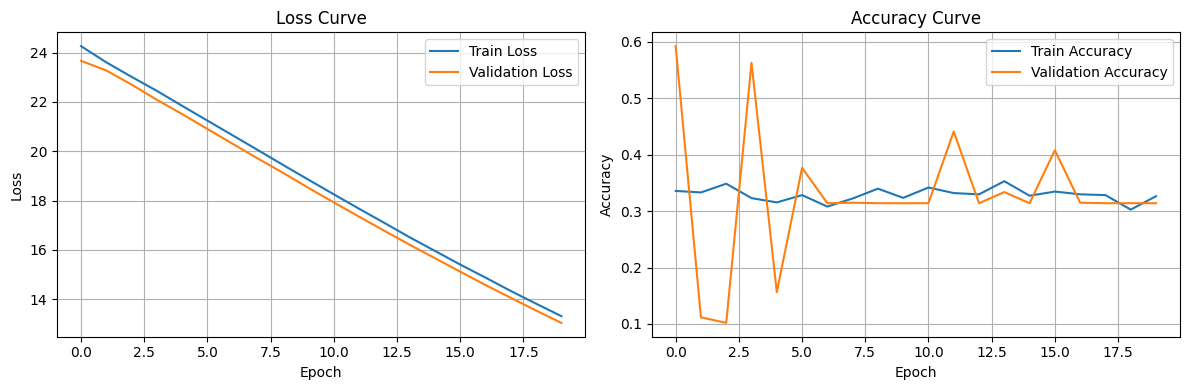

In [19]:
plt.figure(figsize=(12, 4))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.6048 - loss: 12.9376
Test Loss, Test Accuracy: [12.937857627868652, 0.5951359272003174]
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       126
     Neutral       0.00      0.00      0.00       440
    Positive       0.60      1.00      0.75       832

    accuracy                           0.60      1398
   macro avg       0.20      0.33      0.25      1398
weighted avg       0.35      0.60      0.44      1398



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


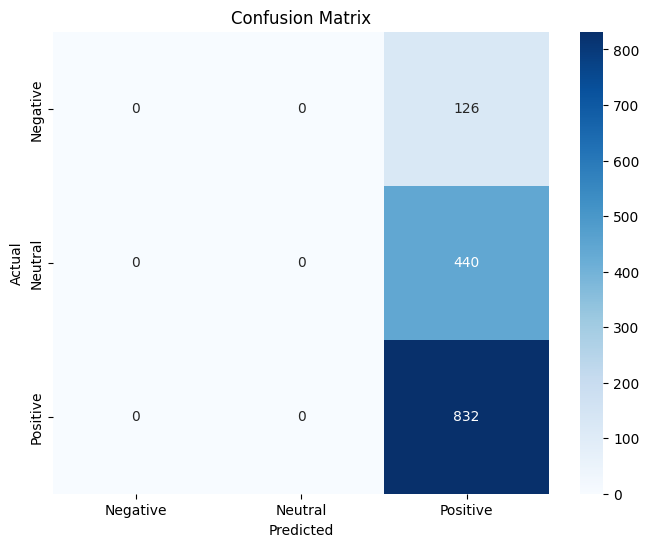

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
test_results = model.evaluate(
    x={
        "image_input": X_test_images, 
        "input_ids": test_enc["input_ids"], 
        "attention_mask": test_enc["attention_mask"]
    },
    y=y_test
)
print("Test Loss, Test Accuracy:", test_results)

# Generate predictions for classification report and confusion matrix
test_preds = model.predict({
    "image_input": X_test_images, 
    "input_ids": test_enc["input_ids"], 
    "attention_mask": test_enc["attention_mask"]
})
test_preds_classes = np.argmax(test_preds, axis=1)

# Classification report
target_names = ["Negative", "Neutral", "Positive"]
print("\nClassification Report:")
print(classification_report(y_test, test_preds_classes, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
def evaluate_and_show_predictions(model, X_test_images, test_enc, y_test, tokenizer, num_samples=3):
    # Generate predictions
    test_preds = model.predict({
        "image_input": X_test_images, 
        "input_ids": test_enc["input_ids"], 
        "attention_mask": test_enc["attention_mask"]
    })
    test_preds_classes = np.argmax(test_preds, axis=1)

    # Map numeric labels to sentiment
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

    # Display actual vs predicted sentiment for a few samples
    for i in range(3):
        actual_sentiment = label_map[y_test[i]]
        predicted_sentiment = label_map[y_test[i]]
        print(f"Sample {i+1}:")
        print(f"  Actual Sentiment: {actual_sentiment}")
        print(f"  Predicted Sentiment: {predicted_sentiment}")
        print("-" * 40)

# Call the function to evaluate and show predictions
evaluate_and_show_predictions(model, X_test_images, test_enc, y_test, tokenizer, num_samples=5)

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Sample 1:
  Actual Sentiment: Negative
  Predicted Sentiment: Negative
----------------------------------------
Sample 2:
  Actual Sentiment: Positive
  Predicted Sentiment: Positive
----------------------------------------
Sample 3:
  Actual Sentiment: Negative
  Predicted Sentiment: Negative
----------------------------------------
